# Imports

In [1]:
from  functools import partial
import numpy as np
import pandas as pd
from plot import *
set_things()


import scipy.integrate
from sklearn.metrics import r2_score

# Loading files

In [2]:
US_State_Data = pd.read_excel (r'USA_Data.xlsx')

#loading population of states
State_pop=(US_State_Data.take([3],axis=1).T).to_numpy()
US_State_pop=[]
for i in State_pop:
    US_State_pop.append(i)
    
#loading states name
State_name=(US_State_Data.take([0],axis=1).T).to_numpy()

statewise_pop = {}
for i in range(len(State_pop[0])):
    statewise_pop.update({State_name[0][i]:State_pop[0][i]})

# Model class

In [3]:
class Multi_SEIR():
    def __init__(self,sub_population_num,l1=None):
        self.n_population = sub_population_num
        self.y = None
        if type(l1)==type([]):
            X0,W0,Y0,Z0,D0 = l1
        else:
            X0 = np.ones((sub_population_num,sub_population_num))*1000
            W0 = np.zeros((sub_population_num,sub_population_num))
            Y0 = np.ones((sub_population_num,sub_population_num))*1
            Z0 = np.zeros((sub_population_num,sub_population_num))
            D0 = np.zeros((sub_population_num,sub_population_num))
        y0 = np.hstack([X0.ravel(),W0.ravel(),Y0.ravel(),Z0.ravel(),D0.ravel()])
        self.y0 = y0
        self.diff = {'X_d':[], 'W_d':[], 'Y_d':[], 'Z_d':[], 'D_d':[],}
        self._spacer = '\n'
    
    def sumit(self,t,y,fs,*args,**kwargs):
        s = np.zeros(self.n_population*self.n_population)
        for i in fs:
            s += i(t,y,self.y,**kwargs)
        return s
    
    def solve(self,t):
        def system(y,t):
            ret = np.hstack([self.sumit(t,y,self.diff[k]) for k in self.diff])
            return ret.ravel()
        args = ()
        self.y = scipy.integrate.odeint(system,self.y0,t,args=args)
    
    def __repr_text(self,text):
        return (self._spacer+text)
    
    def __repr__(self):
        t = self.__repr_text
        text = t("Multi-SEIR model with following parameters:")
        text += t("Total number of sub population: {}".format(self.n_population))
        self._spacer = "\n"
        text += t("Initial conditions: ")
        
        self._spacer = "\n\t"
        n = self.n_population*self.n_population
        names = list(self.diff.keys())
        for i in range(5):
            text += t("{}: ".format(names[i])+self.y0[i*n:i*n+n].reshape(self.n_population,self.n_population).__repr__())

        self._spacer = "\n\n"
        text += t("Transitions:")
        for k,v in self.diff.items():
            self._spacer = "\n\t\n"
            text += t("{}: ".format(k))
            self._spacer = "\n\t\t"
            text += t("{}".format(v))
        
        if type(self.y)!=type(None):
            for i in range(5):
                text += t("{}: ".format(names[i])+self.y[-1][i*n:i*n+n].reshape(self.n_population,self.n_population).__repr__())
            
        return text
    
    def add(self,name,fs):
        if type(fs)!=type([]):
            fs = [fs]
        for f in fs:
            self.diff[name] += [partial(f,dim=self.n_population)]
            

In [4]:
dim = len(State_name[0])
# day 1 = 19th March 2020
State_cases_Data = pd.read_excel (r'state_cases_day.xlsx')
State_cases=(State_cases_Data.take([2],axis=1).T).to_numpy()
Names=(State_cases_Data.take([0],axis=1).T).to_numpy()

# Transition functions

In [5]:
def f(t,y,y_,B=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    N = X+Y+W+Z
    ret =  sign*B*X*(Y.sum(axis=1)/N.sum(axis=1)).reshape(-1,1)
    return ret.ravel()

def g(t,y,y_,sig=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*sig*W
    return ret.ravel()

def h(t,y,y_,gam=0,rho=0,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*gam*Y*(1-rho)
    return ret.ravel()

def q(t,y,y_,rho=0.01,sign=1,dim=1):
    n = dim*dim
    X,W,Y,Z,D = [y[i*n:i*n+n].reshape(dim,dim) for i in range(5)]
    ret = sign*rho*Y
    return ret.ravel()


# Wrapper functions over model for curve fit

In [6]:
def func(t,B,POP=0.32e9,I0=258):
    sig = 1/7
    gam = 1/3
    rho = 0

    x0 = np.array([[POP]])
    y0 = np.array([[I0]])
    w0 = 2*y0
    z0 = 0*y0
    d0 = 0*y0

    model1 = Multi_SEIR(1,[x0,w0,y0,z0,d0])

    model1.add('X_d', [partial(f,B=B,sign=-1),])

    model1.add('W_d', [partial(f,B=B,sign=1),
                        partial(g,sig=sig,sign=-1),])

    model1.add('Y_d', [partial(g,sig=sig,sign=1),
                        partial(h,gam=gam,rho=rho,sign=-1),
                        partial(q,rho=rho,sign=-1),])

    model1.add('Z_d', [partial(h,gam=gam,rho=rho,sign=1),])

    model1.add('D_d', [partial(q,rho=rho,sign=1)])

    model1.solve(t)
    
    ret = model1.y
    
    return ret[:,2]

# Data for US

In [11]:
ydata0 = None
StatesName=[]

cases_data={}
for i in range(0,50):
    pop='{}'.format(Names[0][i*32])
    cases_data.update({pop : State_cases[0][32*i:32*(i+1)]})
    StatesName.append(pop)
    

pop='United States'
cases_data.update({pop : State_cases[0][1643:1675]})

month=['March','April']
def get_data(name,p):
    Data=[]
    for ii in range(0,1):
        for jj in range(4,32):
            Data.append('{} {}'.format(jj,month[ii]))
    for ii in range(1,2):
        for jj in range(1,5):
            Data.append('{} {}'.format(jj,month[ii]))
    
    ydata0 = cases_data[name][p:p+14]
    DATA=Data[p:p+14]
    return ydata0, DATA

def get_data_US(name,p):
    Data=[]
    for ii in range(0,1):
        for jj in range(4,32):
            Data.append('{} {}'.format(jj,month[ii]))
    for ii in range(1,2):
        for jj in range(1,5):
            Data.append('{} {}'.format(jj,month[ii]))
    
    ydata0 = cases_data[name][p:p+14]
    DATA=Data[p:p+14]
    return ydata0, DATA

def get_data_US_plot(name,p):
    Data=[]
    for ii in range(0,1):
        for jj in range(4,32):
            Data.append('{} {}'.format(jj,month[ii]))
    for ii in range(1,2):
        for jj in range(1,5):
            Data.append('{} {}'.format(jj,month[ii]))
    
    ydata0 = cases_data[name][p:p+32]
    DATA=Data[p:p+32]
    return ydata0, DATA

# Curve fitting using scipy.optimize.curve_fit

In [8]:
from scipy.optimize import curve_fit
R0 = None
def get_me_R0(func,ydata0):
    popt, pcov = curve_fit(func,range(len(ydata0)),ydata0,p0=[1])
    R0 = popt*3
    return R0, pcov


# Plots

In [9]:
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.bf'] = 'Arial'
plt.rcParams['axes.formatter.use_mathtext'] = True


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif': ['Arial']})
rc('text', usetex=False)
def set_font(p,plt):
    for size in ['axes.titlesize','axes.labelsize','font.size','figure.titlesize','legend.fontsize','xtick.labelsize','ytick.labelsize']:
        plt.rcParams[size] = p

set_font(26,plt)

In [10]:
def plot_this(name,DATA,ydata0,y,R0,pcov,R2):
    Date = DATA

    label = "Prediction"
    txt = "R$^2$ = {:.2f}\nR$_0$ = {:.2f}".format(R2,*R0.ravel())
    
    plt.gca().text(0.7,0.1,txt,transform=plt.gca().transAxes,)
    
    plt.plot(y,lw=2, label=label )
    
    label = "Observed (I$_0$ = {})".format(ydata0[0])
    plt.plot(ydata0,'D',label=label)

    plt.yscale('log')
    plt.legend(loc=2)
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    
    period = "({} to {}, 2020)".format(Date[0],Date[-1])
    plt.title(name.split('_')[0]+"\n"+"{}".format(period))


Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming


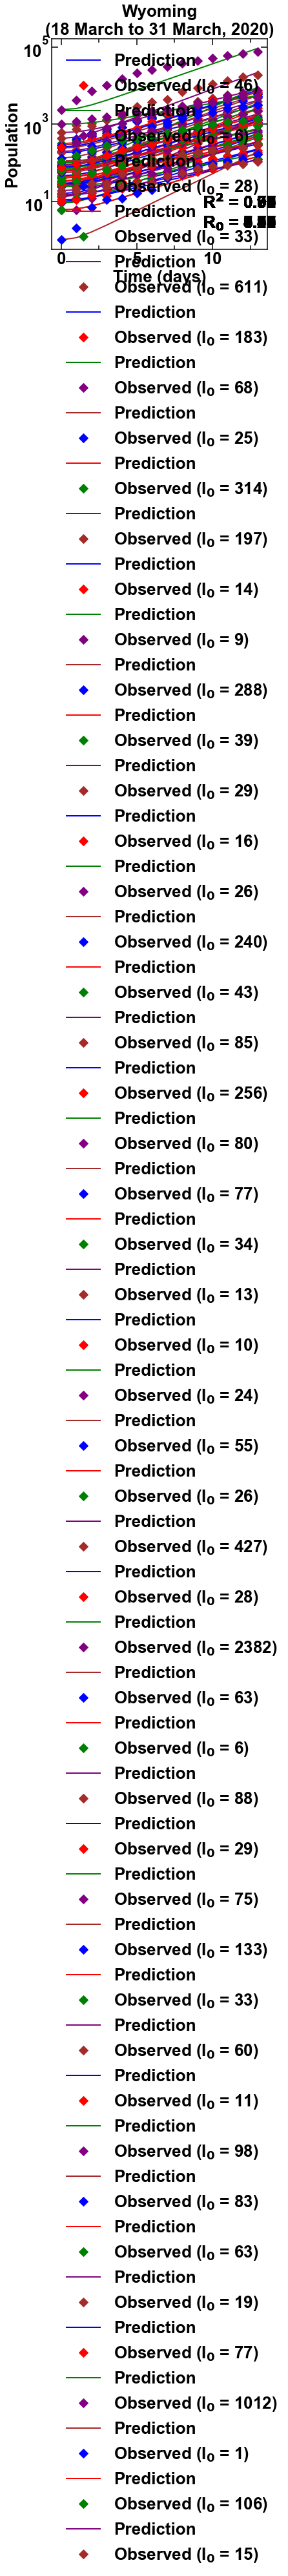

In [13]:
states = StatesName

def optim(state):    
    def g(state,p):
        ydata0, DATA = get_data(state,p)
        f1 = partial(func,POP=statewise_pop[state],I0=ydata0[0])
        R0, pcov = get_me_R0(f1,ydata0)
        y = f1(range(len(ydata0)),R0/3)
        R2 = r2_score(ydata0.ravel(),y.ravel())
        return R2, R0, pcov

    noskip = False
    R2_0 = -100
    R0_0 = np.array([-1])
    i_0 = 40
    pcov_0 = 0
    
    for i in range(14,15):
        R2, R0, pcov = g(state,i)
        if R2_0<R2:
            R2_0 = 1*R2
            R0_0 = 1*R0
            i_0 = 1*i
            pcov_0 = 1*pcov
            
        if R2>0.9:
            ydata0, DATA = get_data(state,i)
            noskip = True
            break

    if noskip:
        f1 = partial(func,POP=statewise_pop[state],I0=ydata0[0])
        y = f1(range(len(ydata0)),R0/3)
        R0_values = {state: [R0[0],R2,pcov[0,0]] }
        plot_this(state,DATA,ydata0,y,R0,pcov,R2)
        return R0_values
    else:
        ydata0, DATA = get_data(state,i_0)
        f1 = partial(func,POP=statewise_pop[state],I0=ydata0[0])
        y = f1(range(len(ydata0)),R0_0/3)
        R0_values = {state: [R0_0[0],R2_0,pcov_0[0,0]]}
        plot_this(state,DATA,ydata0,y,R0_0,pcov_0,R2_0)
        return R0_values
    
def rename(name):
    l = [name[0]]
    for i in name[1:]:
        if i!=i.lower():
            l += [' ']
        l += [i]
    return ''.join(l)
    

R0_values = {}
for state in states:
    fig, ax = panel(1,1,dpi=400,b_p=0.1,t_p=0.1)
    R0_values.update(optim(state))
    filename = "./USA_Images/"+state+".png"
    fig.savefig(filename, bbox_inches = 'tight')
    print(state)

In [14]:
R0_df = pd.DataFrame(list(R0_values.values()),index=R0_values.keys(),columns=['R0','R2','pcov'])
R0_df=R0_df.sort_values(by=['R2'],ascending=False)

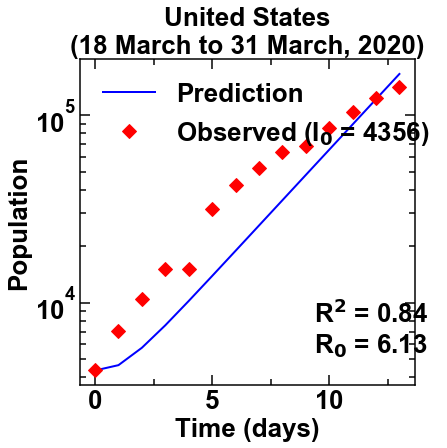

In [15]:
US_ydata0 = State_cases[0][1600:1677]
y1=[]
def optim_US(state):    
    def g(state,p):
        ydata0, DATA = get_data_US(state,p)
        f1 = partial(func,POP=0.32e9,I0=ydata0[0])
        R0, pcov = get_me_R0(f1,ydata0)
        y = f1(range(len(ydata0)),R0/3)
        R2 = r2_score(ydata0.ravel(),y.ravel())
        return R2, R0, pcov

    noskip = False
    R2_0 = 0
    R0_0 = -1
    for i in range(14,15):
        R2, R0, pcov = g(state,i)
        if R2_0<R2:
            R2_0 = R2
            R0_0 = R0
            
        if R2>0.8:
            ydata0, DATA = get_data_US(state,i)
            noskip = True
            break

    if noskip:
        f1 = partial(func,POP=0.32e9,I0=ydata0[0])
        y = f1(range(len(ydata0)),R0/3)
        y1.append(f1(range(200),R0/3))
        R0_values = {state: [R0[0],R2,pcov[0,0]] }
        plot_this(state,DATA,ydata0,y,R0,pcov,R2)
        return R0_values
    else:
        print('nil')
        return {state: [R0_0,R2_0,0] }

R0_values.update(optim_US('United States'))

In [17]:
import pickle

R0 = R0_df['R0']
mask = R0_df['R2']>0.85
R0[~mask] = R0[mask].mean()

mask1 = R0_df['R2']==1
R0[mask1] = R0[mask].mean()

temp_dict = {}
for k,v in zip(R0.index,R0.values):
    temp_dict[k] = v

with open('./R0_week2.dict','wb') as file:
    pickle.dump(temp_dict,file)